## Preprocessing et visualisation

Cette partie de notre analyse se concentre sur l'appréhension du jeu de données et de ces spécificités. Notre travail portera sur la prédiction de la pathologie identifiée à partir des radiographies. Pour cela, nous allons devoir étudier le jeu de données que nous avons en mains avant toute démarche de création de modèle.

Il est important de bien connaitre ses données pour anticiper la démarche suivante.

### Importation des données

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

In [2]:
od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database")

Skipping, found downloaded files in ".\covid19-radiography-database" (use force=True to force download)


In [3]:
COVID_metadata = pd.read_excel('covid19-radiography-database/\COVID-19_Radiography_Dataset/\COVID.metadata.xlsx')
Lung_Opacity_metadata = pd.read_excel('covid19-radiography-database/\COVID-19_Radiography_Dataset/\Lung_Opacity.metadata.xlsx')
Normal_metadata = pd.read_excel('covid19-radiography-database/\COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
Pneumonia_metadata = pd.read_excel('covid19-radiography-database/\COVID-19_Radiography_Dataset/\Viral Pneumonia.metadata.xlsx')

### Exploration des données
#### Les metadatas

In [4]:
print(COVID_metadata.head(), 
      Lung_Opacity_metadata.head(), 
      Normal_metadata.head(), 
      Pneumonia_metadata.head())

  FILE NAME FORMAT     SIZE                                                URL
0   COVID-1    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
1   COVID-2    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
2   COVID-3    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
3   COVID-4    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
4   COVID-5    PNG  256*256  https://sirm.org/category/senza-categoria/covi...         FILE NAME FORMAT     SIZE  \
0  Lung_Opacity-1    PNG  256*256   
1  Lung_Opacity-2    PNG  256*256   
2  Lung_Opacity-3    PNG  256*256   
3  Lung_Opacity-4    PNG  256*256   
4  Lung_Opacity-5    PNG  256*256   

                                                 URL  
0  https://www.kaggle.com/c/rsna-pneumonia-detect...  
1  https://www.kaggle.com/c/rsna-pneumonia-detect...  
2  https://www.kaggle.com/c/rsna-pneumonia-detect...  
3  https://www.kaggle.com/c/rsna-pneumonia-detect...  
4  https://www.kaggle.com/c/

In [5]:
df_metadata = pd.concat([COVID_metadata, Lung_Opacity_metadata, Normal_metadata, Pneumonia_metadata], ignore_index = True)

In [6]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  21165 non-null  object
 1   FORMAT     21165 non-null  object
 2   SIZE       21165 non-null  object
 3   URL        21165 non-null  object
dtypes: object(4)
memory usage: 661.5+ KB


Les quatre fichiers `metadata` fournis sont propres et cohérents, aucune valeur n'est manquante et il n'y a pas d'erreur concernant les types de variables. Les quatres tables suivent la même organisation :
- `FILE NAME` renvoie vers le nom de l'image
- `FORMAT` renvoie le type de fichier
- `SIZE` renvoie la résolution de l'image
- `URL` renvoie la source de l'image sous forme d'un URL

Nous avons donc concaténer les quatre fichiers pour pouvoir travailler plus facilement sur une table unique.

In [7]:
df_metadata.describe()

,FILE NAME,FORMAT,SIZE,URL
count,21165,21165,21165,21165
unique,21165,1,1,8
top,COVID-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
freq,1,21165,21165,14863


Pour la suite de la procédure, nous allons créer notre variable cible, à savoir, le `label` des images en utilisant `FILE NAME`, qui possède le label dans son nom puis un numéro d'identification unique.
De puis, nous allons créer une variable `resolution`qui va simplement être le produit de la hauteur et de la largeur en pixels définis dans la colonne `SIZE`.

In [7]:
df_metadata['LABEL'] = df_metadata['FILE NAME'].str.split('-').str[0]
df_metadata.head()

,FILE NAME,FORMAT,SIZE,URL,LABEL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID


In [8]:
print("Les classes uniques sont :", df_metadata['LABEL'].unique())
print("Les résolutions uniques sont :", df_metadata['SIZE'].unique())
print("Les formats de fichier uniques sont :", df_metadata['FORMAT'].unique())
print("Nombre de radiographies :", len(df_metadata))

Les classes uniques sont : ['COVID' 'Lung_Opacity' 'NORMAL' 'Viral Pneumonia']
Les résolutions uniques sont : ['256*256']
Les formats de fichier uniques sont : ['PNG']
Nombre de radiographies : 21165


En regardant spécifiquement la nature des variables, nous pouvons constater que toutes les images semblent avoir un format unique (\*.png) et une résolution unique (256\*256).
Nous possédons un total de 21165 images provenant de 4 classes différentes :
- NORMAL : individus sains
- COVID : individus positifs au COVID-19
- Viral Pneuomnia : individus souffrant d'une pneumonie
- Lung_Opacity : individus ayant une tâche opaque sur les poumons

Vérifions la véracité de ces données en extrayant les métadonnées des images elles-mêmes.


In [9]:
# Chemin vers le dossier contenant les catégories
root_folder = 'C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/notebooks/covid19-radiography-database/COVID-19_Radiography_Dataset'

# Initialiser une liste pour stocker les métadonnées
data = []

# Parcourir chaque catégorie de dossier
for category in ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']:
    images_folder = os.path.join(root_folder, category, 'images')
    if os.path.isdir(images_folder):
        for image_name in os.listdir(images_folder):
            image_path = os.path.join(images_folder, image_name)
            if os.path.isfile(image_path):
                # Ouvrir l'image pour obtenir des informations supplémentaires
                with Image.open(image_path) as img:
                    width, height = img.size
                    resolution = f"{width}x{height}"
                    channels = img.mode
                    # Convertir le mode de l'image en nombre de canaux
                    # Généralement, 'RGB' -> 3, 'L' -> 1 (niveaux de gris), etc.
                    channels_count = len(channels)
                    # Ajouter les métadonnées à la liste
                    data.append({
                        'FILE NAME': image_name,
                        'FORMAT' : "",
                        'SIZE': resolution,
                        'LABEL': category,
                        'CHANNELS': channels_count,
                        'PATH': image_path})

# Créer un DataFrame à partir des métadonnées collectées
df = pd.DataFrame(data)

# Afficher les premières lignes du DataFrame pour vérifier
print(df.head())

        FILE NAME FORMAT     SIZE  LABEL  CHANNELS  \
0     COVID-1.png         299x299  COVID         1   
1    COVID-10.png         299x299  COVID         1   
2   COVID-100.png         299x299  COVID         1   
3  COVID-1000.png         299x299  COVID         1   
4  COVID-1001.png         299x299  COVID         1   

                                                PATH  
0  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...  
1  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...  
2  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...  
3  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...  
4  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...  


In [10]:
df['FORMAT'] = df['FILE NAME'].str.split('.').str[1]
df['FILE NAME'] = df['FILE NAME'].str.split('.').str[0]
df['FORMAT'] = df['FORMAT'].str.upper()
df.head()


,FILE NAME,FORMAT,SIZE,LABEL,CHANNELS,PATH
0,COVID-1,PNG,299x299,COVID,1,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
1,COVID-10,PNG,299x299,COVID,1,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
2,COVID-100,PNG,299x299,COVID,1,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
3,COVID-1000,PNG,299x299,COVID,1,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
4,COVID-1001,PNG,299x299,COVID,1,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...


In [11]:
print("Les vraies classes uniques sont :", df['LABEL'].unique())
print("Les vraies résolutions uniques sont :", df['SIZE'].unique())
print("Les vrais formats de fichier uniques sont :", df['FORMAT'].unique())
print("Les vrais nombres de canaux sont :", df['CHANNELS'].unique())
print("Nombre de radiographies :", len(df))

Les vraies classes uniques sont : ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']
Les vraies résolutions uniques sont : ['299x299']
Les vrais formats de fichier uniques sont : ['PNG']
Les vrais nombres de canaux sont : [1 3]
Nombre de radiographies : 21165


Ainsi, nous détectons seulement une erreur dans la casse de l'intitulé d'une classe : 'Normal' et non 'NORMAL' ainsi qu'une erreur vis-à-vis des résolutions : '299x299' et non pas '256x256'.
Nous pouvons aussi constater un nombre différents de canaux, avec des images avec un seul canal et d'autres avec 3.

In [12]:
df_true = pd.merge(df, df_metadata[['FILE NAME', 'URL']], on = 'FILE NAME', how = 'left')

In [15]:
# Chemin vers le dossier contenant les catégories
root_folder = 'C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/notebooks/covid19-radiography-database/COVID-19_Radiography_Dataset'

# Initialiser une liste pour stocker les métadonnées
data = []

# Parcourir chaque catégorie de dossier
for category in ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']:
    images_folder = os.path.join(root_folder, category, 'masks')
    if os.path.isdir(images_folder):
        for image_name in os.listdir(images_folder):
            image_path = os.path.join(images_folder, image_name)
            if os.path.isfile(image_path):
                # Ouvrir l'image pour obtenir des informations supplémentaires
                with Image.open(image_path) as img:
                    width, height = img.size
                    resolution = f"{width}x{height}"
                    channels = img.mode
                    # Convertir le mode de l'image en nombre de canaux
                    # Généralement, 'RGB' -> 3, 'L' -> 1 (niveaux de gris), etc.
                    channels_count = len(channels)
                    # Ajouter les métadonnées à la liste
                    data.append({
                        'FILE NAME': image_name,
                        'FORMAT' : "",
                        'SIZE': resolution,
                        'LABEL': category,
                        'CHANNELS': channels_count,
                        'PATH': image_path})

# Créer un DataFrame à partir des métadonnées collectées
df = pd.DataFrame(data)

# Afficher les premières lignes du DataFrame pour vérifier
df['FORMAT'] = df['FILE NAME'].str.split('.').str[1]
df['FILE NAME'] = df['FILE NAME'].str.split('.').str[0]
df['FORMAT'] = df['FORMAT'].str.upper()
df_masks = df
df_masks.head()

,FILE NAME,FORMAT,SIZE,LABEL,CHANNELS,PATH
0,COVID-1,PNG,256x256,COVID,3,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
1,COVID-10,PNG,256x256,COVID,3,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
2,COVID-100,PNG,256x256,COVID,3,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
3,COVID-1000,PNG,256x256,COVID,3,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...
4,COVID-1001,PNG,256x256,COVID,3,C:/Users/Gamy/Desktop/Formation fev24_bootcamp...


In [21]:
print("Les vraies classes uniques sont :", df_masks['LABEL'].unique())
print("Les vraies résolutions uniques sont :", df_masks['SIZE'].unique())
print("Les vrais formats de fichier uniques sont :", df_masks['FORMAT'].unique())
print("Les vrais nombres de canaux sont :", df_masks['CHANNELS'].unique())
print("Nombre de radiographies :", len(df_masks))

Les vraies classes uniques sont : ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']
Les vraies résolutions uniques sont : ['256x256']
Les vrais formats de fichier uniques sont : ['PNG']
Les vrais nombres de canaux sont : [3]
Nombre de radiographies : 21165


#### Distribution des classes cibles

Observons maintenant la distribution du nombre de radiographies par `LABEL`.

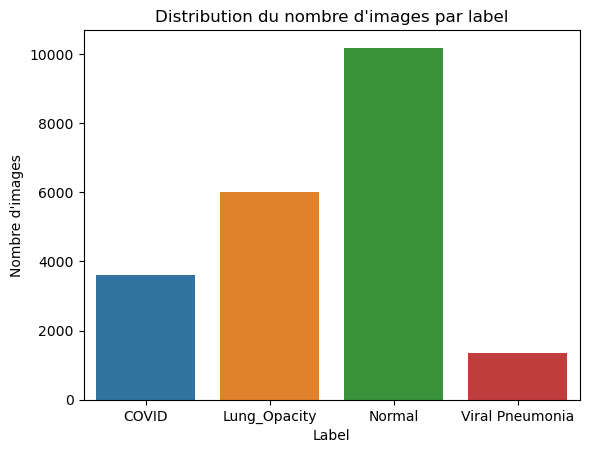

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.countplot(x = 'LABEL', data = df_true)
plt.title("Distribution du nombre d'images par label")
plt.ylabel("Nombre d'images")
plt.xlabel("Label")

plt.show()


Nous constatons que le label ayant le plus de radiographies est la classe 'Normal' puis la classe 'Lung_Opacity' et enfin la classe 'COVID'. A noter que 'Viral Pneumonia' possède moins de 2000 radiographies, ce qui reste correct mais faible à côté des autres classes, ce qui peut risquer une sous-représentation de la classe dans notre futur modèle.

#### Etude des différentes sources

Concentrons-nous maintenant sur les différentes sources des radiographies. Nous possédons des URL, nous allons donc extraire le nom de domaine des URL dans une colonne `SOURCE` afin de les étudier plus précisement.

In [15]:
def source_extract(url):
    pattern = re.compile(r'https?://(?:www\.)?([^/]+)')
    match = pattern.search(url)
    if match:
        return match.group(1)
    else:
        return None

df_true['SOURCE'] = df_true['URL'].astype(str).apply(source_extract)

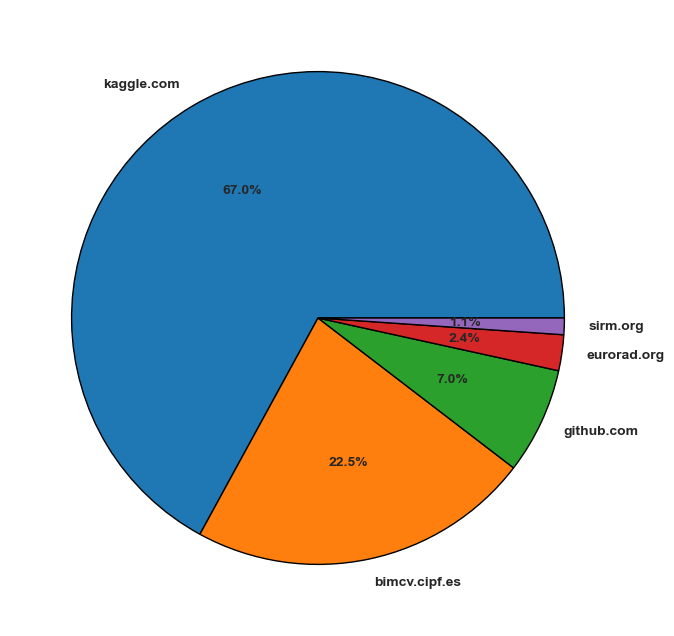

In [16]:
source_counts = df_true['SOURCE'].value_counts()

sns.set_style("whitegrid")
plt.figure(figsize = (8, 8))
plt.pie(source_counts, 
        labels = source_counts.index, 
        autopct = '%1.1f%%', 
        wedgeprops = {'edgecolor': 'black'}, 
        textprops = {'weight': 'bold'})
plt.show()

Nous pouvons constater en effet que kaggle est la principale source de nos données, avec plus de 80% des radiographies issues du site. Moins de 12% des radiographies proviennent de bimcv.cipf.es et moins de 5% sur les trois autres sources.

Ceci s'explique par un évènement créé par Kaggle autour de l'étude des radiographies en ...

#### Qualité et nature des radiographies

Observons maintenant nos radiographies de plus près, afin de détecter d'éventuelles anomalies et pour appréhender la nature de nos images et de leurs spécificités. 

Nous allons sélectionner 5 images aléatoires pour chaque classe et les afficher.

Label: COVID


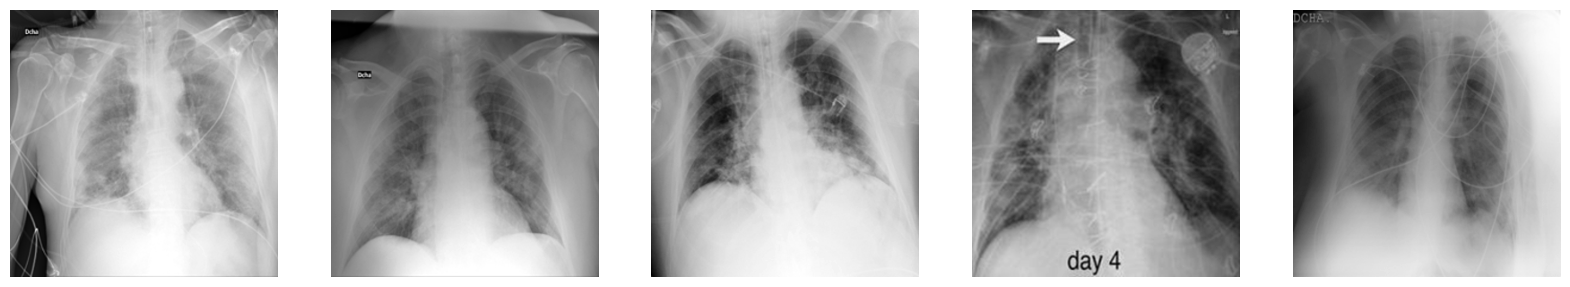

Label: Lung_Opacity


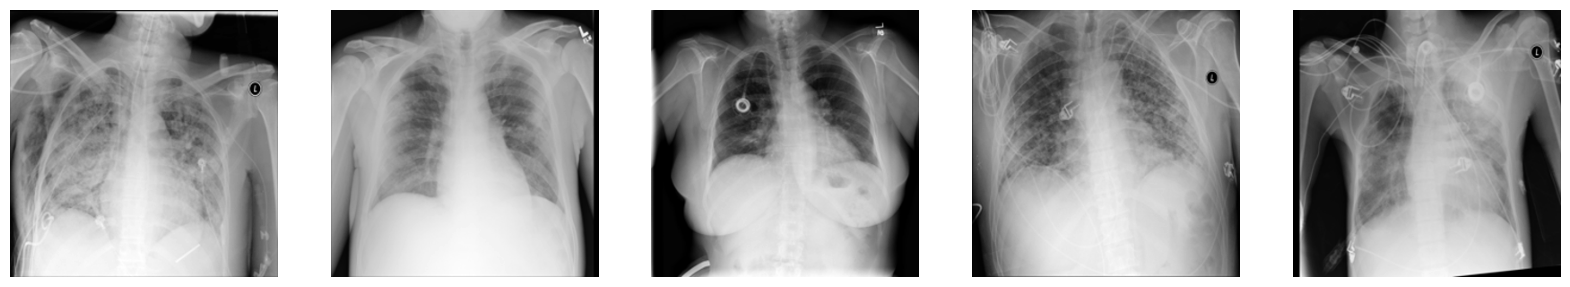

Label: Normal


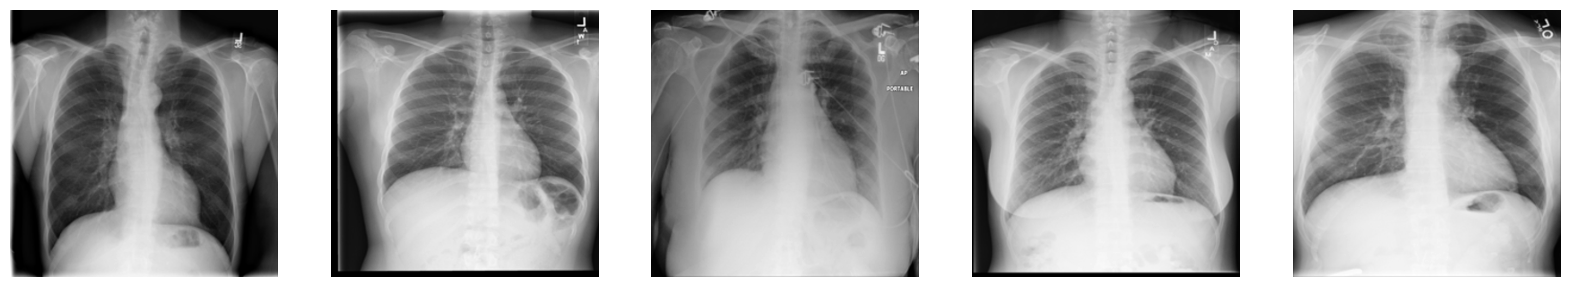

Label: Viral Pneumonia


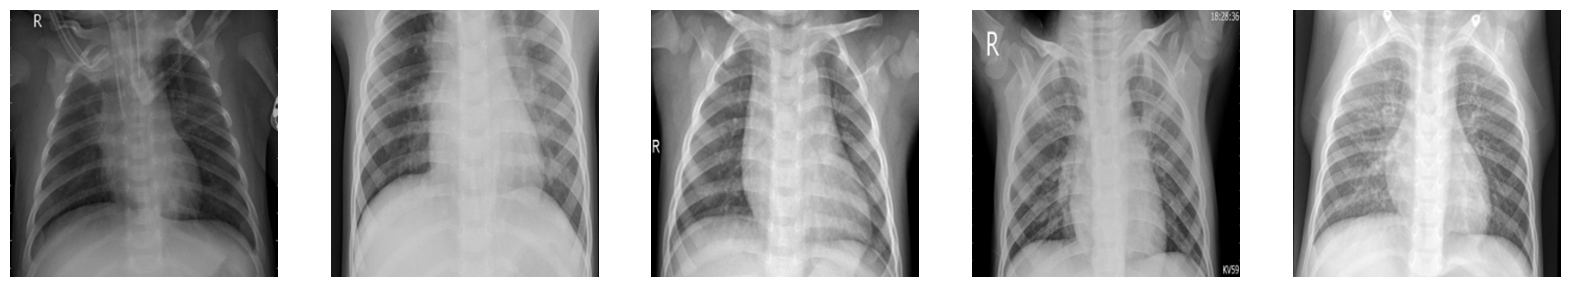

In [17]:
def sample_paths(group):
    return group.sample(n = 5)

# Sélectionner 5 chemins aléatoires pour chaque label
sampled_paths = df_true.groupby('LABEL')['PATH'].apply(sample_paths).reset_index(drop = True)

# Afficher 5 images aléatoires pour chaque label
for label, group in df_true.groupby('LABEL'):
    print(f"Label: {label}")
    sampled_paths = group['PATH'].sample(min(len(group), 5))
    fig, axs = plt.subplots(1, len(sampled_paths), figsize=(20, 20))
    for ax, path in zip(axs, sampled_paths):
        img = mpimg.imread(path)
        ax.imshow(img, cmap = "gray")
        ax.axis('off')
    plt.show()


Il est très intéressant de noter que toutes nos radiographies semblent bien toutes être en nuances de gris. Nous pouvons aussi observer des logos signatures provenant des différents centres de radiographies et quelques dates sur certaines des radiographies. Certaines images semblent être de moins bonne qualité, avec une luminosité beaucoup moins importante.

Nous pouvons noter que toutes les radiographies semblent être prises sous un même angle, de face, selon le protocole adéquat, il y a cependant quelques variations où les patients lèvent les bras ou le zoom de la radiographie plus ou moins marqué. Ces éléments de variabilité sont des atoûts pour le futur modèle qui en tirera une bonne généralisation. L'important étant que les poumons soient bien visibles sur chacune des radiographies.

Nous pouvons noter par ailleurs que certains patient possèdent des tâches avec des fils, il peut s'agir de sondes naso-gastriques, de peacemakers ou d'électrodes qui ne devraient pas poser de problèmes à notre futur modèle.

En plus des images, le jeu de données a, pour chaque image, un masque associé.

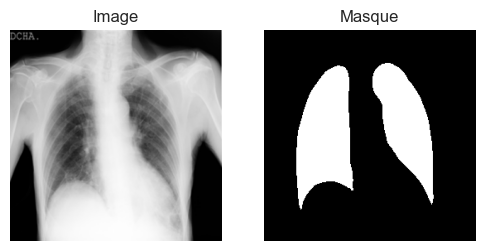

In [18]:
img = cv2.imread("C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/notebooks/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-76.png")
mask = cv2.imread("C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/notebooks/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks/COVID-76.png")

fig, axes = plt.subplots(1, 2, figsize = (6, 4))

axes[0].imshow(img, cmap = "gray")
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap = "gray")
axes[1].set_title('Masque')
axes[1].axis('off')

plt.show()


Nous pouvons constater que le masque représente le contour spécifique des poumons. Ces masques nous serons particulièrement utiles car ils nous permettront de faire abstraction des éléments non pertinents présents autour de cette zone pouvant altérer les résultats. Car en effet, nous allons nous concentrer uniquement sur les poumons pour notre problématique.

Maintenant que nous savons que toutes nos images sont bien en nuances de gris, nous allons étudier la distribution de l'intensité lumineuse des pixels, qui correspond à la principale source de variabilité entre nos images.

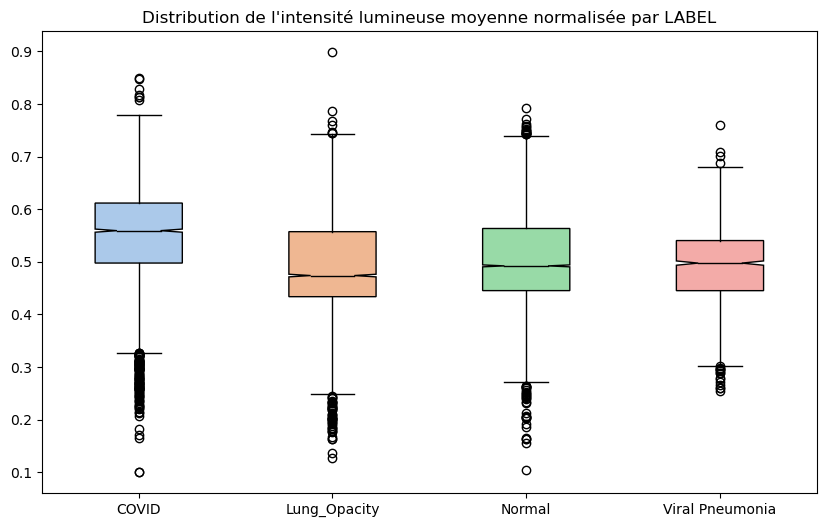

In [23]:
# Fonction pour calculer l'intensité lumineuse moyenne d'une image
def calc_mean_intensity(image_path):
    img = mpimg.imread(image_path)
    # Convertir en nuances de gris si l'image est en couleur
    if img.ndim == 3:
        img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    else:
        img_gray = img
    return np.mean(img_gray)

# Appliquer la fonction à chaque chemin d'image pour obtenir l'intensité moyenne
df_true['MEAN_INTENSITY'] = df_true['PATH'].apply(calc_mean_intensity)
data_to_plot = [group['MEAN_INTENSITY'].values for _, group in df_true.groupby('LABEL')]
labels = df_true['LABEL'].unique()

boxplot_colors = ['#abc9ea', '#efb792', '#98daa7', '#f3aba8']
median_color = 'black'

plt.figure(figsize = (10, 6))
box = plt.boxplot(data_to_plot, notch = True, labels = labels, patch_artist = True)

for patch, color in zip(box['boxes'], boxplot_colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color(median_color)

plt.title("Distribution de l'intensité lumineuse moyenne normalisée par LABEL")
plt.show()


Les boites à moustaches nous permettent de visualiser la distribution en fonction des différents `label`.

Nous pouvons observer que les radiographies de la classe 'COVID' semble être les plus lumineux et à contrario, les radiographies de la classe 'Lung_Opacity' semblent être les plus sombres. 
Nous pouvons observer que les classes 'NORMAL' et 'Viral Pneumonia' sont assez similaires, et semblent avoir une médiane très proche. Il s'agit d'une information pertinente à conserver pour la suite de notre étude.

Illustrons ces distributions sur des violinplots pour plus de faciliter à l'interpretation des distributions.

    FILE NAME FORMAT     SIZE  LABEL  CHANNELS  \
0     COVID-1    PNG  299x299  COVID         1   
1    COVID-10    PNG  299x299  COVID         1   
2   COVID-100    PNG  299x299  COVID         1   
3  COVID-1000    PNG  299x299  COVID         1   
4  COVID-1001    PNG  299x299  COVID         1   

                                                PATH  \
0  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...   
1  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...   
2  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...   
3  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...   
4  C:/Users/Gamy/Desktop/Formation fev24_bootcamp...   

                                                 URL  MEAN_INTENSITY  \
0  https://sirm.org/category/senza-categoria/covi...        0.572145   
1  https://sirm.org/category/senza-categoria/covi...        0.554335   
2  https://sirm.org/category/senza-categoria/covi...        0.599524   
3  https://github.com/ieee8023/covid-chestxray-da...        0.638318   
4 

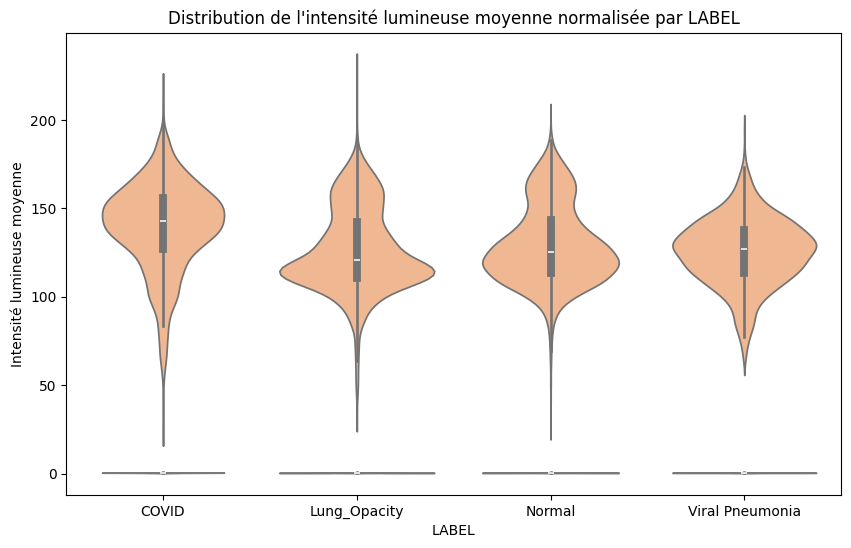

In [4]:
df_true = pd.read_csv('C:/Users/Gamy/Desktop/Formation fev24_bootcamp_ds/chest_radiography_covid19/datasets/processed/df_images.csv')
print(df_true.head())
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'LABEL', y = 'MEAN_INTENSITY', data = df_true)
sns.violinplot(x = "LABEL", y = "MEAN_INTENSITY_ORIGINAL", data = df_true)
sns.set_palette("pastel")
plt.ylabel('Intensité lumineuse moyenne')
plt.title("Distribution de l'intensité lumineuse moyenne normalisée par LABEL")
plt.show()

Cette représentation est préférable pour identifier la distribution des valeurs. En effet, la largeur des "violons" donnent une idée de la distribution de la probabilité de chaque classe. Les patients de la classe 'COVID' semblent bien avoir une distribution d'intensité plus élevée que les patients sains, ce qui indiquerait des caractéristiques radiographiques plus prononcées dans les images des poumons.

Les classes 'Lung_Opacity' et 'Viram Pneumonia' présentent des distributions d'intensité élévée, ce qui est cohérent avec la présence d'anomalies pulmonaires qui pourraient augmenter l'intensité lumineuse moyenne dans les radiographies.

Les radiographies des patients sains ont une distribution centrée plus bas, ce qui suggère une intensité lumineuse moins élevée, comme nous pouvons nous y attendre.